# Assignment6
## CS-5891-01 Special Topics Deep Learning
## Ronald Picard

In this notebook we will walk through the design, training, and testing of neural networks with multiple hidden layers using minibatch stochastic gradient descent with momentum. These neural networks will be used for logistic regression, which is an archaic name for binary classification.

The binary classification will be performed on images of handwritten numerical digits. More specifically, the last numerical digit of my student ID. This digit happens to be 9. Therefore, the goal of our neural networks will be to output a the value of 1 when the handwritten numerical digit image input is a 9, and 0 in all other cases.

The data set we will be using is the MNIST data set. This is a very popular data set amoung the machine learning community. The data set contains 60,000 images, and each image contains a handwritten numerical digit. Each of the images have been provided with a truth label that corresponds to the handwritten digit within the image from the set {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. 

For our case, we only care about when the image is 9. Therefore we will need to re-label the truth labels so that all truth labels with the value of 9 are given to the value of 1, and all other truth labels are given the value of 0. 

To start we need to import some needed classes.

In [86]:
import os
import numpy as np
import struct
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pyplot
import csv
import time

First, we must change our path string to the path of our data file containing the features. (Please note that you must change this string to point to the directory with the data file on your machine data file on your machine.) 

Second, we much change the string name of the data files to the names of the MNIST data files. (Please note that you may NOT need to change these. Only change them if your MINST data files are named differently.)

In [87]:
## path
path = 'C:/Users/computer/OneDrive - Vanderbilt/Vanderbilt_Spring_2019/CS_5891_01_SpecialTopicsDeepLearning/Assignment2/'

#Train data
fname_train_images = os.path.join(path, 'train-images.idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels.idx1-ubyte')  # the training set label file path

Next, we retrieve the data from the data files as follows. This imports the data into a feature tensor (3-D matrix) in which each index is a feature matrix corresponding to an image. The label data comes in the form of a vector where each index corresponds to the index of the feature matrix (image) of the feature tensor.  

In [88]:
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows, cols)

print('The training set contains', len(images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', images[0].shape)  # print the shape of the image

The training set contains 60000 images
The shape of the image is (28, 28)


Next, we need to perform both two steps; feature scaling and feature normalization. Feature scaling consists of converting the 28 X 28 image matrices into 784 X 1 feature vectors. In essence we will flatten the images out into vectors so that we can use an input a vector to our single neuron. Feature normalization is a process of normalizing the pixel data to between 0 <= x <= 1 (for logistic regression). Each pixel comes on a scale of 0 <= x <= 255. Since 255 is the maximum for every pixel we shall divide each pixel by that number (elementwise) in order to normalize each pixel to between 0 and 1 (inclusive).

One additional item we need to take care of is relabeling our label (truth) data so that we have a binary classification in which all 9s are converted to 1s and all other labels are converted to 0s.

In [89]:
# feature scaling
matrix_side_length = len(images[0])
vector_size = matrix_side_length*matrix_side_length

scaled_images_feature_matrix = []
for image in images:
    reshaped_image = np.array(image).reshape((vector_size))
    scaled_images_feature_matrix.append(reshaped_image)

# convert to numpy array
scaled_images_feature_matrix = np.transpose(np.array(scaled_images_feature_matrix))
print(scaled_images_feature_matrix.shape) # scaled_images_feature_matrix is a matrix of 60000 X 784
#print(scaled_images_feature_matrix[0].shape)

# feature normilization
normilization_factor = 1/255
normalized_scaled_images_feature_matrix = np.multiply(normilization_factor, scaled_images_feature_matrix)
print(normalized_scaled_images_feature_matrix.shape)
#print(normalized_scaled_images_feature_matrix[0])

# re-label for binary classification
value_for_1 = 9
binary_labels = []
for label in labels:
    if(label == 9):
        binary_labels.append(1)
    else:
        binary_labels.append(0)

# convert to numpy array
binary_labels = np.array(binary_labels)
print(len(binary_labels)) # binary_labels is a row vector of 1 X 60000
#print(binary_labels[0])


(784, 60000)
(784, 60000)
60000


In order to test the efficacy of our neural networks, we need to split up the our label data into two data sets; a smaller and a larger one. The larger set will be the training data that we will use to train our neural networks on. The smaller set will be the testing data that we will used to test the accuracy of our neural nets. The MNIST data set contains 60,000 images. Therefore, we will use 50,000 images for our training data set, and 10,000 images for our testing data set. 

It is common practice to use a smaller subset of the total data set to debug (ensure it works) and tune hyper-parameters before using the entire time-comsuming data set. This smaller subset is known as a validation set. Therefore, we will first use a validation data set of 600 images. 500 of these images will be used for as our training data set, and the other 100 of these images will be used for our test data set. 

Thus, we will begin by sifting out a validation set from our total data set.

In [90]:
# create a data set
size = vector_size

number_of_testing_images = 100
number_of_training_images = 500
number_of_validation_images = number_of_testing_images + number_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

factor = 0
for index in range(0, number_of_validation_images):
    if(index <= number_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        training_labels.append(binary_labels[index + factor])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        testing_labels.append(binary_labels[index + factor])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
print(training_images.shape) # validation_training_images is a matrix of 784 X 500
print(training_labels.shape) # validation_testing_labels is a row vector of 1 X 500
print(testing_images.shape) # validation_training_images is a matrix of 784 X 100
print(testing_labels.shape)  # validation_testing_labels is a row vector of 1 X 100

(784, 500)
(500,)
(784, 100)
(100,)


Now we move on to the training of our neural network with multiple hidden layers. 

Part 1 - Feed Forword:

For these neural networks we will use multiple hidden layers with between 5-20 units per layer (neurons). The first layer will have an input of a matrix (784 X number_of_images) of vectorized images of 784 X 1, and will output a matrix (# of units X # of images). This matrix will be input into the next hidden layer, which output another matrix (# of units X # of images.) The output layer will take and input matrix that is the output matrix of the last hidden layer and will output a row vector of probabilities which we will convert into binary classifications of 0 or 1. (If P(x) >= 0.5 then we will convert it to a 1, otherwise we will convert to 0.) 

The model for the units of the hidden layers will be a vecorized linear model Z^[l] = W^[l]^T * A^[l-1] + B^[l], where W is a matrix of 5-10 units (# of units) X # of units or parameter weights, A is the input matrix of vectorized images (784 X # of images) or the output of one of the layers (1 X # of units), and B is a row vector of bias's. (Note: in this case, b will be scalar that applied in a broadcasing manner to save on memory.) The output of this model Z^[l] will be a matrix (5-10 units X # of images). Z^[1] will be subject to an activation function; which for this assignment will be relu (note: we will test tanh once for comparison). 

Hidden Layer Activation Function: relu activation function is A^[1]  = relu(Z) =  max(Z, 0).

The model of the output layer will be a vectorized linear model Z^[1] = W^[l] * A^[1] + b^[l] with a single unit. This linear model will be subjected to a sigmoid activation function.

The resultant row vector will then be used to calculate the cost function values in an elementwise manner. The cost function for this binary classification will be L(Y_Predicted, Y_Label) = -Y_Label^[l] * Log(A^[l]) - (1-Y_Predicted^[l]) * Log(1-A^[l]), where Y_Label is the True Label, Y_Predicted is the probability value predicted by the neural network, and A is the activation function value. The resultant cost row vector will be added up and divided by the number of elements in order to calculate the average cost.

Part 2 - Back Propogation:

The back propogation technique that we will use for training the neural network, will be gradient descent. This involves utilizing the gradient of the cost function to updated the model parameters in our layers. In order to calculate the gradient we will utilize the chain rule. The goal of back propogation is the adjust the parameter weights and bias's of our model to accurately perform binary classification. In general the chain rule can be used to find the gradient of the cost function (vecorzied rates of change) with respect to the model parameters. The following is the chain that we will utilize. 


Generalized Chain Rule for N layers: 

dL(A^[n], Y)/dW^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dz^[l]/dW^[l];

dL(A^[n], Y)/dB^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dz^[l]/dB^[l];



Output Layer - Back Propogation:

The partial derivative of the cost function with respect to the output layer sigmoid activation function is found by the following:

dL(A^[n], Y)/dA^[n] = -Y/A^[n] + (1-A^[n])/(1-A^[n]).


Due to the chain rule, the derivative of the cost function with respect to the linear model Z^[n] is found by the following:

dL(A^[n], y)/dz = dL(A^[n], y)/dA^[n] * dA^[n]/dZ^[n].

The derivative of the sigmoid activation function is da/dz is found by the following:

dA^[n]/dZ^[n] = sigma(Z^[n]) * (1-sigma(Z^[n]))

Therefore, the derivative of the cost function with respect to the output of the linear model is found by the following:

dL(A^[n], Y)/dA^[n] * dA^[n]/dZ^[n]. = (-Y/A^[n] + (1-Y)/(1-A^[n])) * (sigma(Z^[n]) * (1-sigma(Z^[n]))) = A^[n]-Y. (For convienence we will say dZ^[n] = A^[n]-Y.)

Now we can extrapolate the chain rule to all the paramters of the linear model our output layer.

dL(A^[n], Y)/dW^[n] = dZ^[n] * dZ^[n]/dW^[n] = dZ^[n] * A^[n-1] = A^[n-1] * dZ^[n] (we will change our notation to dW^[n] = A^[n-1] * dZ^[n] for convienence)

dL(A^[n], Y)/dB^[n] = dZ^[n] * dZ^[n]/dB^[n] = dZ^[n] (we will change our notation to dW^[n] = dZ^[n] for convienence)



Hidden Layers - Back Propagation:

dL(A^[n], Y)/dZ^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dA^[l]/dZ^[l]

dL(A^[n], Y)/dZ^[l] = dZ^[l+1] * dZ^[l+1]/dA^[l] = W^[l+1] * dz^[l+1] * (element-wise) dA^[1]/dZ^[1]. The reason this is element-wise is because we are propgating from a single neuron to a layer with multiple neurons (we shall rename this dz^[l] = W^[l+1] * dz^[l+1] * (element-wise) dA^[1]/dZ^[1] for conveinience) 

dA^[1]/dZ^[1] depends on the activation function we are using in the hidden layer (in this case relu): The derivative of relu activation function is dA^[l]/dZ^[l] = if Z^[l] > 0 then 1 else 0.


dL(A^[n], Y)/dW^[l] = dZ^[l] * dZ^[l]/dW^[l] = dZ^[l] * X^T (we will change our notation to dW^[l] = dZ^[l] * A[l-1]^T for convienence)

dL(A^[n], Y)/dB^[l] = dZ^[l] * dZ^[l]/dB^[l] = dZ^[l] (we will change our notation to dB^[l] = dZ^[l] for convienence)


Find vector averages:

m = # number of images

dW^[l] = 1/m * (A^[l-1] * dZ^[l])

dB^[l] = 1/m * (dZ^[l])


Finally, we will update our the weights and bias's of the layers.


W^[l]:= W^[l] - alpha * dW^[l]

B^[l]:= B^[l] - alpha * dB^[l]


The first thing we have have to do is initialize our weights and bias's. There are multiple ways to initialize weights and bias's. Typically we will set our values based on either a uniform distribution between or a normal distribution with a some reasonable mean and standard deviation. There is some flexibility in the initalization of the weights but in general they need to be small (not to small) and varied. The weights need to be different so that the gradients with respect to each other are different. In other words we don't aways want the relative rates of change to be 0. Additionally, we do not want to reach saturation on our output activation function where the gradients are 0 (vanishing gradiants). For this assignment we wills stick with with a uniform random between -.1 and .1. We will also set a random seed each time so that we fors our random values to be the same (or similar if there are more layers).

In [91]:
# initialize weights & bias
np.random.seed(10)
print('Feature Size: ' + str(size))

lower_bound = -.1
upper_bound = .1

#mean = 0.015
#std = 0.005

# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
V_dW = []
V_dB = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], size]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], units_array[i-1]]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
_V_dW = np.float64(np.zeros([1, units_array[i]]))
_V_dB = np.float64(np.zeros(1))
Weights.append(_W)
Bias.append(_b)
V_dW.append(_V_dW)
V_dB.append(_V_dB)

Weights = np.array(Weights)
Bias = np.array(Bias)
V_dW = np.array(V_dW)
V_dB = np.array(V_dB)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit
print('Velocity Weights Shape: ' + str(V_dW[0].shape)) # matrix with a size of # of units X 784
print('Velocity Bias Shape: ' + str(V_dB[0].shape)) # vector with a size of the # of unit

Feature Size: 784
Weights Shape: (20, 784)
Bias Shape: (20, 1)
Velocity Weights Shape: (20, 784)
Velocity Bias Shape: (20, 1)


Now we implement our minibatch stochastic gradient descent algorithm. The only difference betwen minibatch stochasic gradient descent and general full-batch gradient descent is that during every epoch (run) we split up our training data into minibatches based on the specified minibatch size. If they data does not evenly split, then the last batch will be smaller; so that we utilize all of the trainig data during every epoch. Then during evey epoch we train once on each minibatch. Since we are training on minibatches, our path the extrema of the function we are tryign to find will not as direct. Therefore, our cost and test accuracy will not decrease every epoch; however, the general trend will be decreasing. Minibatch gradient decense will help prevent us from getting stuck on local extrema, as well as increase the speed at which the code runs.

We will also collect data on the accuracy of our networks as a function of training iterations. To do this we will need to find the number of inaccuracate binary classifications (false positives & false negatives). This will be acommplished using our test data set. We will send our test data set through the network and compare the results with the true labels of the test data set. 

Main Loop Epoch: 100
Number Of Minibatches: 10
Cost: 0.0024360064743517867
Main Loop Epoch: 200
Number Of Minibatches: 10
Cost: 0.0011374617457707798
Main Loop Epoch: 300
Number Of Minibatches: 10
Cost: 0.0002504582126068609
Main Loop Epoch: 400
Number Of Minibatches: 10
Cost: 0.0002903632841629266

Results:


Run Time: 4.991669654846191 seconds
Cost: 0.00019616014290038203
Accuracy: 95.0 %




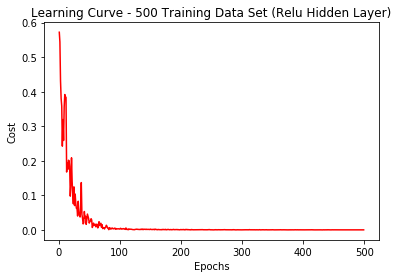

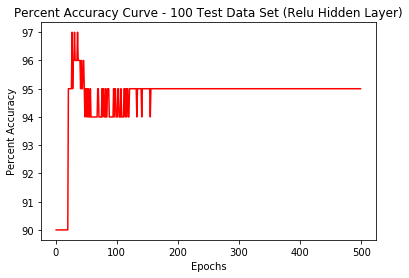

In [92]:
# gradient descent
detailed_logger = False
main_logger = True
main_logger_output_epochs = 100
L2 = False
Dropout = False
momentum = False
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .1;
epsilon = .85
keep_prob = .9
number_of_epochs = 500
batch_size = 50
momentum_coef = .9

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X_train = np.float64(training_images).copy()
Y_train = np.float64(training_labels).copy()

X_test = np.float64(testing_images).copy()
Y_test = np.float64(testing_labels).copy()

#m = size
m = number_of_training_images

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-20
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/L.shape[1], np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*W.shape[1]), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/Y.shape[0], np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/dZ.shape[1], np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/Z.shape[1], W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/dZ.shape[1], np.sum(dZ))

def backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        if(momentum == True):
            V_dW[layer] = np.multiply(momentum_coef, V_dW[layer]) + np.multiply(alpha, _dW)
            V_dB[layer] = np.multiply(momentum_coef, V_dB[layer]) + np.multiply(alpha, _dB)
            W[layer] = W[layer] - V_dW[layer]
            B[layer] = B[layer] - V_dB[layer]           
        else:
            W[layer] = W[layer] - np.multiply(alpha, _dW)
            B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

def shuffle(X, Y, number_of_training_images):
    random_array = np.random.permutation(np.arange(number_of_training_images))
    return X[:, random_array], Y[random_array]
    
start_time = time.time()   
# main loop
for epoch in range(1, number_of_epochs):
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Main Loop Epoch: ' + str(epoch))
    
    # shuffle data
    X, Y = shuffle(X_train.copy(), Y_train.copy(), number_of_training_images)
    number_of_batches = int(np.floor(number_of_training_images/batch_size))
    split_index = number_of_batches*batch_size

    # parse into minibatches
    X_minibatches = np.split(X[:, 0:split_index], number_of_batches, axis=1)
    if not(split_index == number_of_training_images):
        X_left_over_portion  = X[:, split_index:number_of_training_images]
        X_minibatches.append(X_left_over_portion)
    
    Y_minibatches = np.split(Y[0:split_index], number_of_batches, axis=0)
    if not(split_index == number_of_training_images):
        Y_left_over_portion  = Y[split_index:number_of_training_images]
        Y_minibatches.append(Y_left_over_portion)
    
    number_of_minibatches = len(Y_minibatches)
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Number Of Minibatches: ' + str(number_of_minibatches))

    for index in range(0, number_of_minibatches-1):
        X_minibatch = X_minibatches[index]
        Y_minibatch = Y_minibatches[index]

        if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
            print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
            break

        # forward propogation training data set
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X_minibatch, [X_minibatch], [], 0, [], keep_prob)
        L = loss(A_layers[len(A_layers) - 1], Y_minibatch)
        if(L2 == True):
            C = cost_L2(L, W, epsilon) 
        else:
            C = cost(L) 

        # backpropogation
        W, B = backward_propagation(W, B, Y_minibatch, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D,  V_dW, V_dB)
        
    if(epoch % main_logger_output_epochs == 0):
        print('Cost: ' + str(C))

    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)

    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  

    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(epoch)


end_time = time.time()
run_time = end_time - start_time
    
print('')
print('Results:')
print('')
    
print('')
print('Run Time: ' + str(run_time) + ' seconds')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy) + ' %')    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As shown, our validation set worked, so now we can move on to the full data set, and begin our evaluation and exploration.

First, we need to split up our full data set into testing and training data. We will use 50,000 images as the training data set and 10,000 images as the testing data set. 

In [93]:
# create a data set
size = vector_size

number_of_testing_images = 10000
number_of_training_images = 50000
number_of_validation_images = number_of_testing_images + number_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

factor = 0
for index in range(0, number_of_validation_images):
    if(index <= number_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        training_labels.append(binary_labels[index + factor])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        testing_labels.append(binary_labels[index + factor])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
print(training_images.shape) # validation_training_images is a matrix of 784 X 500
print(training_labels.shape) # validation_testing_labels is a row vector of 1 X 500
print(testing_images.shape) # validation_training_images is a matrix of 784 X 100
print(testing_labels.shape)  # validation_testing_labels is a row vector of 1 X 100

(784, 50000)
(50000,)
(784, 10000)
(10000,)


Now we must reset out weights and bias's. 

In [11]:
# initialize weights & bias
np.random.seed(10)
print('Feature Size: ' + str(size))

lower_bound = -.1
upper_bound = .1

#mean = 0.015
#std = 0.005

# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
V_dW = []
V_dB = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], size]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], units_array[i-1]]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
_V_dW = np.float64(np.zeros([1, units_array[i]]))
_V_dB = np.float64(np.zeros(1))
Weights.append(_W)
Bias.append(_b)
V_dW.append(_V_dW)
V_dB.append(_V_dB)

Weights = np.array(Weights)
Bias = np.array(Bias)
V_dW = np.array(V_dW)
V_dB = np.array(V_dB)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit
print('Velocity Weights Shape: ' + str(V_dW[0].shape)) # matrix with a size of # of units X 784
print('Velocity Bias Shape: ' + str(V_dB[0].shape)) # vector with a size of the # of unit

Feature Size: 784
Weights Shape: (20, 784)
Bias Shape: (20, 1)
Velocity Weights Shape: (20, 784)
Velocity Bias Shape: (20, 1)


Now we re-run minibatch stochastic gradient descent on the full data set. We will first utilize minibatches of 500 each.

Main Loop Epoch: 100
Number Of Minibatches: 100
Cost: 0.040280227907951584
Main Loop Epoch: 200
Number Of Minibatches: 100
Cost: 0.02568970533038529
Main Loop Epoch: 300
Number Of Minibatches: 100
Cost: 0.020037735231309108
Main Loop Epoch: 400
Number Of Minibatches: 100
Cost: 0.026541878026984538
Main Loop Epoch: 500
Number Of Minibatches: 100
Cost: 0.013543108816859831
Main Loop Epoch: 600
Number Of Minibatches: 100
Cost: 0.013648362081607569
Main Loop Epoch: 700
Number Of Minibatches: 100
Cost: 0.007825852764969
Main Loop Epoch: 800
Number Of Minibatches: 100
Cost: 0.009420266622494554
Main Loop Epoch: 900
Number Of Minibatches: 100
Cost: 0.004402508996987994
Main Loop Epoch: 1000
Number Of Minibatches: 100
Cost: 0.0020197110841280795
Main Loop Epoch: 1100
Number Of Minibatches: 100
Cost: 0.0033471696372207216
Main Loop Epoch: 1200
Number Of Minibatches: 100
Cost: 0.0036489103960996574
Main Loop Epoch: 1300
Number Of Minibatches: 100
Cost: 0.001718017371077936
Main Loop Epoch: 1400


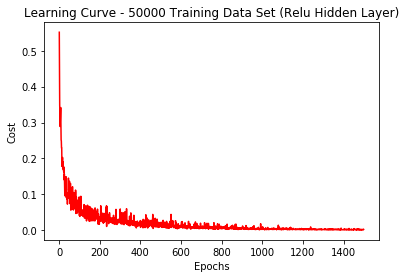

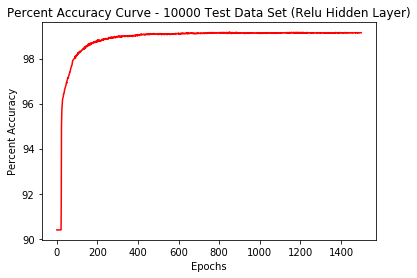

In [12]:
# gradient descent
detailed_logger = False
main_logger = True
main_logger_output_epochs = 100
L2 = False
Dropout = False
momentum = False
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .85
keep_prob = .9
number_of_epochs = 1500
batch_size = 500
momentum_coef = .9

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X_train = np.float64(training_images).copy()
Y_train = np.float64(training_labels).copy()

X_test = np.float64(testing_images).copy()
Y_test = np.float64(testing_labels).copy()

#m = size
m = number_of_training_images

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-20
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/L.shape[1], np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*W.shape[1]), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/Y.shape[0], np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/dZ.shape[1], np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/Z.shape[1], W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/dZ.shape[1], np.sum(dZ))

def backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        if(momentum == True):
            V_dW[layer] = np.multiply(momentum_coef, V_dW[layer]) + np.multiply(alpha, _dW)
            V_dB[layer] = np.multiply(momentum_coef, V_dB[layer]) + np.multiply(alpha, _dB)
            W[layer] = W[layer] - V_dW[layer]
            B[layer] = B[layer] - V_dB[layer]           
        else:
            W[layer] = W[layer] - np.multiply(alpha, _dW)
            B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

def shuffle(X, Y, number_of_training_images):
    random_array = np.random.permutation(np.arange(number_of_training_images))
    return X[:, random_array], Y[random_array]
    
start_time = time.time()   
# main loop
for epoch in range(1, number_of_epochs):
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Main Loop Epoch: ' + str(epoch))
    
    # shuffle data
    X, Y = shuffle(X_train.copy(), Y_train.copy(), number_of_training_images)
    number_of_batches = int(np.floor(number_of_training_images/batch_size))
    split_index = number_of_batches*batch_size

    # parse into minibatches
    X_minibatches = np.split(X[:, 0:split_index], number_of_batches, axis=1)
    if not(split_index == number_of_training_images):
        X_left_over_portion  = X[:, split_index:number_of_training_images]
        X_minibatches.append(X_left_over_portion)
    
    Y_minibatches = np.split(Y[0:split_index], number_of_batches, axis=0)
    if not(split_index == number_of_training_images):
        Y_left_over_portion  = Y[split_index:number_of_training_images]
        Y_minibatches.append(Y_left_over_portion)
    
    number_of_minibatches = len(Y_minibatches)
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Number Of Minibatches: ' + str(number_of_minibatches))

    for index in range(0, number_of_minibatches-1):
        X_minibatch = X_minibatches[index]
        Y_minibatch = Y_minibatches[index]

        if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
            print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
            break

        # forward propogation training data set
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X_minibatch, [X_minibatch], [], 0, [], keep_prob)
        L = loss(A_layers[len(A_layers) - 1], Y_minibatch)
        if(L2 == True):
            C = cost_L2(L, W, epsilon) 
        else:
            C = cost(L) 

        # backpropogation
        W, B = backward_propagation(W, B, Y_minibatch, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D,  V_dW, V_dB)
        
    if(epoch % main_logger_output_epochs == 0):
        print('Cost: ' + str(C))

    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)

    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  

    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(epoch)


end_time = time.time()
run_time = end_time - start_time
    
print('')
print('Results:')
print('')
    
print('')
print('Run Time: ' + str(run_time) + ' seconds')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy) + ' %')    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As illustrated the after 1400 epochs with minibatches of 500 the cost became approximately 0.001859 and the test data accuracy reached 99.15%. These results are very good. The test accuracy is high because minibatch stochastic gradient descent inately provides a form of regularization.

We now wish to explore the impact of adjusting the minibatch size. We will re-run the algorithm with a smaller minibatch size of 27 and see what the results we achieve.

First we reinitialize our weights and bias's.

In [94]:
# initialize weights & bias
np.random.seed(10)
print('Feature Size: ' + str(size))

lower_bound = -.1
upper_bound = .1

#mean = 0.015
#std = 0.005

# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
V_dW = []
V_dB = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], size]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], units_array[i-1]]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
_V_dW = np.float64(np.zeros([1, units_array[i]]))
_V_dB = np.float64(np.zeros(1))
Weights.append(_W)
Bias.append(_b)
V_dW.append(_V_dW)
V_dB.append(_V_dB)

Weights = np.array(Weights)
Bias = np.array(Bias)
V_dW = np.array(V_dW)
V_dB = np.array(V_dB)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit
print('Velocity Weights Shape: ' + str(V_dW[0].shape)) # matrix with a size of # of units X 784
print('Velocity Bias Shape: ' + str(V_dB[0].shape)) # vector with a size of the # of unit

Feature Size: 784
Weights Shape: (20, 784)
Bias Shape: (20, 1)
Velocity Weights Shape: (20, 784)
Velocity Bias Shape: (20, 1)


Now we re-run our minibatch stochastic gradient descent algorithm.

Main Loop Epoch: 100
Number Of Minibatches: 1852
Cost: 0.00040557499288796804
Main Loop Epoch: 200
Number Of Minibatches: 1852
Cost: 0.00022533569347979733
Main Loop Epoch: 300
Number Of Minibatches: 1852
Cost: 8.647075623703261e-09
Main Loop Epoch: 400
Number Of Minibatches: 1852
Cost: 4.046850915373965e-05

Results:


Run Time: 744.6950306892395 seconds
Cost: 1.6063560949634133e-05
Accuracy: 99.18 %




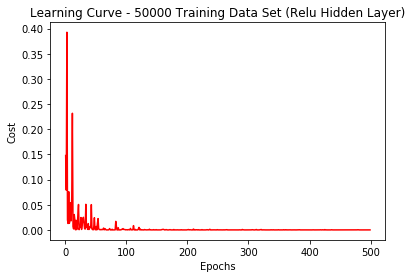

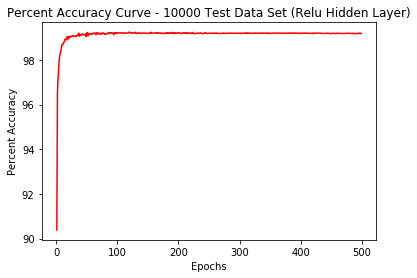

In [69]:
# gradient descent
detailed_logger = False
main_logger = True
main_logger_output_epochs = 100
L2 = False
Dropout = False
momentum = False
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .85
keep_prob = .9
number_of_epochs = 500
batch_size = 27
momentum_coef = .9

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X_train = np.float64(training_images).copy()
Y_train = np.float64(training_labels).copy()

X_test = np.float64(testing_images).copy()
Y_test = np.float64(testing_labels).copy()

#m = size
m = number_of_training_images

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-20
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/L.shape[1], np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*W.shape[1]), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/Y.shape[0], np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/dZ.shape[1], np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/Z.shape[1], W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/dZ.shape[1], np.sum(dZ))

def backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        if(momentum == True):
            V_dW[layer] = np.multiply(momentum_coef, V_dW[layer]) + np.multiply(alpha, _dW)
            V_dB[layer] = np.multiply(momentum_coef, V_dB[layer]) + np.multiply(alpha, _dB)
            W[layer] = W[layer] - V_dW[layer]
            B[layer] = B[layer] - V_dB[layer]           
        else:
            W[layer] = W[layer] - np.multiply(alpha, _dW)
            B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

def shuffle(X, Y, number_of_training_images):
    random_array = np.random.permutation(np.arange(number_of_training_images))
    return X[:, random_array], Y[random_array]
    
start_time = time.time()   
# main loop
for epoch in range(1, number_of_epochs):
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Main Loop Epoch: ' + str(epoch))
    
    # shuffle data
    X, Y = shuffle(X_train.copy(), Y_train.copy(), number_of_training_images)
    number_of_batches = int(np.floor(number_of_training_images/batch_size))
    split_index = number_of_batches*batch_size

    # parse into minibatches
    X_minibatches = np.split(X[:, 0:split_index], number_of_batches, axis=1)
    if not(split_index == number_of_training_images):
        X_left_over_portion  = X[:, split_index:number_of_training_images]
        X_minibatches.append(X_left_over_portion)
    
    Y_minibatches = np.split(Y[0:split_index], number_of_batches, axis=0)
    if not(split_index == number_of_training_images):
        Y_left_over_portion  = Y[split_index:number_of_training_images]
        Y_minibatches.append(Y_left_over_portion)
    
    number_of_minibatches = len(Y_minibatches)
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Number Of Minibatches: ' + str(number_of_minibatches))

    for index in range(0, number_of_minibatches-1):
        X_minibatch = X_minibatches[index]
        Y_minibatch = Y_minibatches[index]

        if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
            print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
            break

        # forward propogation training data set
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X_minibatch, [X_minibatch], [], 0, [], keep_prob)
        L = loss(A_layers[len(A_layers) - 1], Y_minibatch)
        if(L2 == True):
            C = cost_L2(L, W, epsilon) 
        else:
            C = cost(L) 

        # backpropogation
        W, B = backward_propagation(W, B, Y_minibatch, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D,  V_dW, V_dB)
        
    if(epoch % main_logger_output_epochs == 0):
        print('Cost: ' + str(C))

    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)

    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  

    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(epoch)


end_time = time.time()
run_time = end_time - start_time
    
print('')
print('Results:')
print('')
    
print('')
print('Run Time: ' + str(run_time) + ' seconds')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy) + ' %')    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As illustrated, after 500 epochs with minibatches of 27 the cost became approximately 1.6e-05 and the test data accuracy reached 99.18%. These results are very good. The test accuracy is high because minibatch stochastic gradient descent inately provides a form of regularization.

Additionally, it should be noted that this algorithm reached convergence in approximatley 120 epochs, which was much less than with larger minibatches. 

Now we will run minibatch stochastic gradient descent with momentum. Momentum is a tehcnique that takes into account the historical rate of change (velocity) of the gradients when adjusting the weights and bias's rather than strictly adjusting them based on the current gradient. This momentum intuitively reflects a ball heading a down a hill to the bottom. When the hill (gradient) is steep for several steps, momentum picks up and the ball heads to its destination faster. Implementing momentum should helps use arrive at convergence in a quicker manner. With this in mind, we implement a new hyper-parameter for momentum which controls the amoung of focus we put on the gradient momentum versus the current gradient. We will start by setting this momentum coefficient to 0.9 in order to heavely focus on the momentum of the gradient. We will leave our minibatch size at 27 since we have achieved good results with it. 

First we reinitialize our weights and bias's.

In [7]:
# initialize weights & bias
np.random.seed(10)
print('Feature Size: ' + str(size))

lower_bound = -.1
upper_bound = .1

#mean = 0.015
#std = 0.005

# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
V_dW = []
V_dB = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], size]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], units_array[i-1]]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
_V_dW = np.float64(np.zeros([1, units_array[i]]))
_V_dB = np.float64(np.zeros(1))
Weights.append(_W)
Bias.append(_b)
V_dW.append(_V_dW)
V_dB.append(_V_dB)

Weights = np.array(Weights)
Bias = np.array(Bias)
V_dW = np.array(V_dW)
V_dB = np.array(V_dB)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit
print('Velocity Weights Shape: ' + str(V_dW[0].shape)) # matrix with a size of # of units X 784
print('Velocity Bias Shape: ' + str(V_dB[0].shape)) # vector with a size of the # of unit

Feature Size: 784
Weights Shape: (20, 784)
Bias Shape: (20, 1)
Velocity Weights Shape: (20, 784)
Velocity Bias Shape: (20, 1)


Now we run our minibatch stochastic gradient descent algorithm with momentum.

Main Loop Epoch: 10
Number Of Minibatches: 1852
Cost: 0.003075740130681305
Main Loop Epoch: 20
Number Of Minibatches: 1852
Cost: 0.0002421045249690861
Main Loop Epoch: 30
Number Of Minibatches: 1852
Cost: 0.0001461015181742864
Main Loop Epoch: 40
Number Of Minibatches: 1852
Cost: 0.001100090690208689
Main Loop Epoch: 50
Number Of Minibatches: 1852
Cost: 4.661676444755369e-07
Main Loop Epoch: 60
Number Of Minibatches: 1852
Cost: 2.430669273114621e-07
Main Loop Epoch: 70
Number Of Minibatches: 1852
Cost: 1.0348610490080223e-06
Main Loop Epoch: 80
Number Of Minibatches: 1852
Cost: 6.290041172420984e-08
Main Loop Epoch: 90
Number Of Minibatches: 1852
Cost: 4.956932166353874e-09

Results:


Run Time: 229.67204904556274 seconds
Cost: 6.6395106245545e-08
Accuracy: 99.22 %




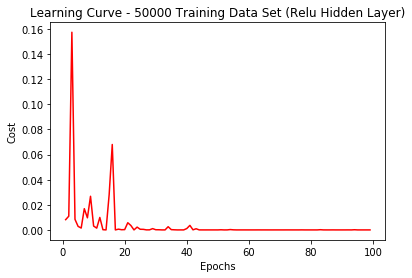

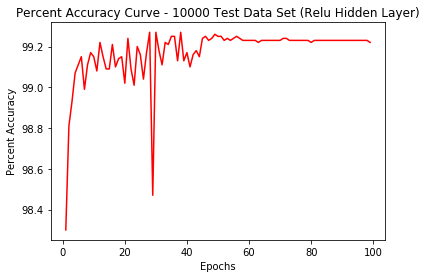

In [8]:
# gradient descent
detailed_logger = False
main_logger = True
main_logger_output_epochs = 10
L2 = False
Dropout = False
momentum = True
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .85
keep_prob = .9
number_of_epochs = 100
batch_size = 27
momentum_coef = .9

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X_train = np.float64(training_images).copy()
Y_train = np.float64(training_labels).copy()

X_test = np.float64(testing_images).copy()
Y_test = np.float64(testing_labels).copy()

#m = size
m = number_of_training_images

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-20
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/L.shape[1], np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*W.shape[1]), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/Y.shape[0], np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/dZ.shape[1], np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/Z.shape[1], W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/dZ.shape[1], np.sum(dZ))

def backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        if(momentum == True):
            V_dW[layer] = np.multiply(momentum_coef, V_dW[layer]) + np.multiply(alpha, _dW)
            V_dB[layer] = np.multiply(momentum_coef, V_dB[layer]) + np.multiply(alpha, _dB)
            W[layer] = W[layer] - V_dW[layer]
            B[layer] = B[layer] - V_dB[layer]           
        else:
            W[layer] = W[layer] - np.multiply(alpha, _dW)
            B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

def shuffle(X, Y, number_of_training_images):
    random_array = np.random.permutation(np.arange(number_of_training_images))
    return X[:, random_array], Y[random_array]
    
start_time = time.time()   
# main loop
for epoch in range(1, number_of_epochs):
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Main Loop Epoch: ' + str(epoch))
    
    # shuffle data
    X, Y = shuffle(X_train.copy(), Y_train.copy(), number_of_training_images)
    number_of_batches = int(np.floor(number_of_training_images/batch_size))
    split_index = number_of_batches*batch_size

    # parse into minibatches
    X_minibatches = np.split(X[:, 0:split_index], number_of_batches, axis=1)
    if not(split_index == number_of_training_images):
        X_left_over_portion  = X[:, split_index:number_of_training_images]
        X_minibatches.append(X_left_over_portion)
    
    Y_minibatches = np.split(Y[0:split_index], number_of_batches, axis=0)
    if not(split_index == number_of_training_images):
        Y_left_over_portion  = Y[split_index:number_of_training_images]
        Y_minibatches.append(Y_left_over_portion)
    
    number_of_minibatches = len(Y_minibatches)
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Number Of Minibatches: ' + str(number_of_minibatches))

    for index in range(0, number_of_minibatches-1):
        X_minibatch = X_minibatches[index]
        Y_minibatch = Y_minibatches[index]

        if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
            print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
            break

        # forward propogation training data set
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X_minibatch, [X_minibatch], [], 0, [], keep_prob)
        L = loss(A_layers[len(A_layers) - 1], Y_minibatch)
        if(L2 == True):
            C = cost_L2(L, W, epsilon) 
        else:
            C = cost(L) 

        # backpropogation
        W, B = backward_propagation(W, B, Y_minibatch, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D,  V_dW, V_dB)
        
    if(epoch % main_logger_output_epochs == 0):
        print('Cost: ' + str(C))

    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)

    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  

    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(epoch)


end_time = time.time()
run_time = end_time - start_time
    
print('')
print('Results:')
print('')
    
print('')
print('Run Time: ' + str(run_time) + ' seconds')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy) + ' %')    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As illustrated, after 100 epochs with minibatches of 27 the cost became approximately 6.6395e-08 and the test data accuracy reached 99.22%. These results are excellent. The test accuracy is high because minibatch stochastic gradient descent inately provides a form of regularization. In fact, we converged in approximatley 45 iterations to a very high accuracy and low cost. This lines up with what we would intuitively expect by adding in momentum. Our algorithm focused highly on the historical trend of the gradient rather than each step, and as a result converged faster.

Now we wish to explore the impact of adjusting the momentum hyper-paramter. Therefore, we will adjust its value to .1 and re-run our algorithm. 

First we reinitialize our weights and bias's.

In [13]:
# initialize weights & bias
np.random.seed(10)
print('Feature Size: ' + str(size))

lower_bound = -.1
upper_bound = .1

#mean = 0.015
#std = 0.005

# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
V_dW = []
V_dB = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], size]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        _V_dW = np.float64(np.zeros([units_array[i], units_array[i-1]]))
        _V_dB = np.float64(np.zeros([units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
        V_dW.append(_V_dW)
        V_dB.append(_V_dB)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner
_V_dW = np.float64(np.zeros([1, units_array[i]]))
_V_dB = np.float64(np.zeros(1))
Weights.append(_W)
Bias.append(_b)
V_dW.append(_V_dW)
V_dB.append(_V_dB)

Weights = np.array(Weights)
Bias = np.array(Bias)
V_dW = np.array(V_dW)
V_dB = np.array(V_dB)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit
print('Velocity Weights Shape: ' + str(V_dW[0].shape)) # matrix with a size of # of units X 784
print('Velocity Bias Shape: ' + str(V_dB[0].shape)) # vector with a size of the # of unit

Feature Size: 784
Weights Shape: (20, 784)
Bias Shape: (20, 1)
Velocity Weights Shape: (20, 784)
Velocity Bias Shape: (20, 1)


Now we re-run our minibatch stochastic gradient descent algorithm with momentum.

Main Loop Epoch: 10
Number Of Minibatches: 1852
Cost: 0.01529208269507389
Main Loop Epoch: 20
Number Of Minibatches: 1852
Cost: 0.004077579948707226
Main Loop Epoch: 30
Number Of Minibatches: 1852
Cost: 0.028170922925060595
Main Loop Epoch: 40
Number Of Minibatches: 1852
Cost: 0.0042440696729762
Main Loop Epoch: 50
Number Of Minibatches: 1852
Cost: 0.0001764298629206007
Main Loop Epoch: 60
Number Of Minibatches: 1852
Cost: 0.00039509593526748134
Main Loop Epoch: 70
Number Of Minibatches: 1852
Cost: 2.1314596748085606e-06
Main Loop Epoch: 80
Number Of Minibatches: 1852
Cost: 8.821269877158751e-06
Main Loop Epoch: 90
Number Of Minibatches: 1852
Cost: 2.0576062738186753e-06

Results:


Run Time: 261.67622208595276 seconds
Cost: 0.0002186226582897106
Accuracy: 99.16 %




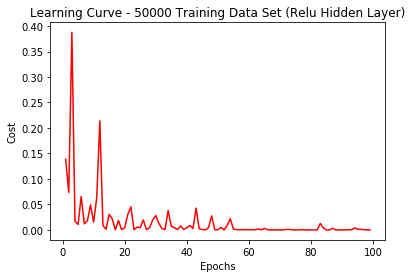

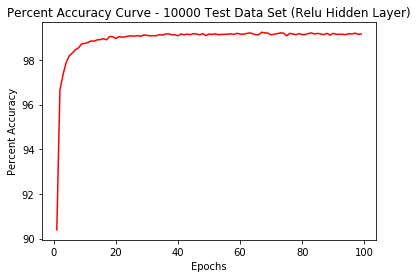

In [14]:
# gradient descent
detailed_logger = False
main_logger = True
main_logger_output_epochs = 10
L2 = False
Dropout = False
momentum = True
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .85
keep_prob = .9
number_of_epochs = 100
batch_size = 27
momentum_coef = .1

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X_train = np.float64(training_images).copy()
Y_train = np.float64(training_labels).copy()

X_test = np.float64(testing_images).copy()
Y_test = np.float64(testing_labels).copy()

#m = size
m = number_of_training_images

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-20
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/L.shape[1], np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*W.shape[1]), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/Y.shape[0], np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, A.shape) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/dZ.shape[1], np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/Z.shape[1], W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/dZ.shape[1], np.sum(dZ))

def backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        if(momentum == True):
            V_dW[layer] = np.multiply(momentum_coef, V_dW[layer]) + np.multiply(alpha, _dW)
            V_dB[layer] = np.multiply(momentum_coef, V_dB[layer]) + np.multiply(alpha, _dB)
            W[layer] = W[layer] - V_dW[layer]
            B[layer] = B[layer] - V_dB[layer]           
        else:
            W[layer] = W[layer] - np.multiply(alpha, _dW)
            B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, Y, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D, V_dW, V_dB)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

def shuffle(X, Y, number_of_training_images):
    random_array = np.random.permutation(np.arange(number_of_training_images))
    return X[:, random_array], Y[random_array]
    
start_time = time.time()   
# main loop
for epoch in range(1, number_of_epochs):
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Main Loop Epoch: ' + str(epoch))
    
    # shuffle data
    X, Y = shuffle(X_train.copy(), Y_train.copy(), number_of_training_images)
    number_of_batches = int(np.floor(number_of_training_images/batch_size))
    split_index = number_of_batches*batch_size

    # parse into minibatches
    X_minibatches = np.split(X[:, 0:split_index], number_of_batches, axis=1)
    if not(split_index == number_of_training_images):
        X_left_over_portion  = X[:, split_index:number_of_training_images]
        X_minibatches.append(X_left_over_portion)
    
    Y_minibatches = np.split(Y[0:split_index], number_of_batches, axis=0)
    if not(split_index == number_of_training_images):
        Y_left_over_portion  = Y[split_index:number_of_training_images]
        Y_minibatches.append(Y_left_over_portion)
    
    number_of_minibatches = len(Y_minibatches)
    
    # logger
    if(main_logger == True and epoch % main_logger_output_epochs == 0):
        print('Number Of Minibatches: ' + str(number_of_minibatches))

    for index in range(0, number_of_minibatches-1):
        X_minibatch = X_minibatches[index]
        Y_minibatch = Y_minibatches[index]

        if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
            print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
            break

        # forward propogation training data set
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X_minibatch, [X_minibatch], [], 0, [], keep_prob)
        L = loss(A_layers[len(A_layers) - 1], Y_minibatch)
        if(L2 == True):
            C = cost_L2(L, W, epsilon) 
        else:
            C = cost(L) 

        # backpropogation
        W, B = backward_propagation(W, B, Y_minibatch, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D,  V_dW, V_dB)
        
    if(epoch % main_logger_output_epochs == 0):
        print('Cost: ' + str(C))

    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)

    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  

    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(epoch)


end_time = time.time()
run_time = end_time - start_time
    
print('')
print('Results:')
print('')
    
print('')
print('Run Time: ' + str(run_time) + ' seconds')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy) + ' %')    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Epochs')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As illustrated, after 100 epochs with minibatches of 27 the cost became approximately 0.0002186 and the test data accuracy reached 99.16%. These results are excellent. The test accuracy is high because minibatch stochastic gradient descent inately provides a form of regularization. This time, we converged in approximatley 55 iterations to a very high accuracy and low cost. This lines up with what we would intuitively expect by making the momentum coefficient low. Our algorithm focused less on historical trend of the gradient and more on each step. As a results we converged slower than with a higher momentum coefficient.

We have illustrated how the minibatch stochastic gradient provies many benefits for training neural networks. This technique provides a form of regularization by preventing the network from getting stuck local minima. The networks also converge faster. We have also explored how taking into account the momentum of the gradient can speed up the convergence of the network.